In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

from model import ControlVAE
from encoders import EncoderControlVAE
from decoders import DecoderControlVAE

from utils.helpers import plot_epoch, save_model
from utils.loss import get_losses


In [2]:
import onnx as onnx


In [3]:
"""
PROPERTIES
All of them are normalized

0. - x coordinate of max pixel
1. - y coordinate of max pixel
2. - x coordinate of mass center
3. - y coordinate of mass center
4. - number of non zero pixels
5. - categorized number of non zero pixels
6. - sum of pixels
7. - max pixel value
"""

properties = [2, 3]
properties_cond = [7, 8]


In [4]:
"""
ARGUMENTS
"""

device = 'cpu'

results_dir = '/content/drive/MyDrive/models/'
data_source = './data/dataset_nonrandom_responses_test.pth'

img_size = (1, 44, 44)
latent_dim = 8
latent_dim_prop = 8
latent_dim_cond = 8
cond_dim = 9

hid_channels = 64

num_prop = len(properties)
num_prop_cond = len(properties_cond)

lr = 1e-4

batch_size = 64
epochs = 250

beta = 1
taus = 0.2
idx_kl = 0
w_kl = 100

lambdas = [
    1000000,    # reconstruction_loss
    1,          # pairwise_tc_loss
    5000000,    # reconstruction_prop_loss
    1,          # kl_loss
    1,          # groupwise_wz_loss
    1,          # groupsize_wc_loss
    1000000,    # reconstruction_prop_cond_loss
    1           # groupwise_cz_loss
]


In [5]:
"""
DATA
"""

data = torch.load(data_source)
dataset = TensorDataset(data['features'], data['labels'])

train_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)


In [6]:
"""
MODEL
"""

encoder = eval("EncoderControlVAE")
decoder = eval("DecoderControlVAE")

model = ControlVAE(img_size, encoder, decoder, latent_dim, latent_dim_prop,
                   latent_dim_cond, cond_dim, num_prop, num_prop_cond, device=device)
model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=lr)

lr_scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[50, 100, 150, 200],
        gamma=0.1
)

mse_loss = torch.nn.MSELoss(reduction="sum")

recon_loss_prop_rec = []
recon_loss_rec = []
kl_loss_rec = []
pwwi_loss_rec = []
pwz_loss_rec = []
l1_loss_rec = []
mask_rec = []


In [7]:
model.load_state_dict(torch.load("./models/modelCorrVAE_99_8_8_8.pt", map_location=torch.device('cpu'))['model_state_dict'])
model = model.to(device)
model.eval()


ControlVAE(
  (encoder): EncoderControlVAE(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=512, bias=True)
    (lin2): Linear(in_features=512, out_features=512, bias=True)
    (mu_logvar_gen): Linear(in_features=512, out_features=32, bias=True)
    (lin1_cond): Linear(in_features=9, out_features=512, bias=True)
    (lin2_cond): Linear(in_features=512, out_features=512, bias=True)
    (mu_logvar_gen_cond): Linear(in_features=512, out_features=16, bias=True)
  )
  (decoder): DecoderControlVAE(
    (property_lin_list): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=1, out_features=16, bias=True)
        (1): LeakyReLU(negative_slope=0.1)
        (2): Linear(in_features=16, out_features=1, bias=True)
        (3): Sigmoid()
      )
     

In [21]:
from torchviz import make_dot


make_dot((data, cond, taus), params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")


AttributeError: 'float' object has no attribute 'size'

In [15]:
import torch.onnx

# input_names = ['Sentence']
# output_names = ['yhat']
# torch.onnx.export(model, 'rnn.onnx', input_names=input_names, output_names=output_names)
x = torch.randn(batch_size, 1, 44, 44, requires_grad=True)
c = torch.randn(batch_size, 9, requires_grad=True)
tau = 2e-20

torch.onnx.export(model, (x, c, tau), 'rnn.onnx')


========== Diagnostic Run torch.onnx.export version 2.0.0.dev20221220 ==========
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 1 ERROR ========================
ERROR: missing-standard-symbolic-function
Exporting the operator 'aten::exponential' to ONNX opset version 14 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.
<Set verbose=True to see more details>




/Users/karolrogozinski/opt/anaconda3/lib/python3.9/site-packages/torch/onnx/utils.py:619: UserWarning: ONNX Preprocess - Removing mutation from node aten::copy_ on block input: 'encoder.lin1_cond.weight_sigma'. This changes graph semantics. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1671523943921/work/torch/csrc/jit/passes/onnx/remove_inplace_ops_for_onnx.cpp:355.)
  _C._jit_pass_onnx_remove_inplace_ops_for_onnx(graph, module)
/Users/karolrogozinski/opt/anaconda3/lib/python3.9/site-packages/torch/onnx/utils.py:619: UserWarning: ONNX Preprocess - Removing mutation from node aten::copy_ on block input: 'encoder.lin2_cond.weight_sigma'. This changes graph semantics. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1671523943921/work/torch/csrc/jit/passes/onnx/remove_inplace_ops_for_onnx.cpp:355.)
  _C._jit_pass_onnx_remove_inplace_ops_for_onnx(graph, module)
/Users/karolrogozinski/opt/anaconda3/lib/python3.9/site-packages/torch

UnsupportedOperatorError: Exporting the operator 'aten::exponential' to ONNX opset version 14 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.

In [11]:
import torchvision
from torchview import draw_graph

model_graph = draw_graph(model input_size=(1,44,44), expand_nested=True)
model_graph.visual_graph


SyntaxError: invalid syntax (2646263672.py, line 4)

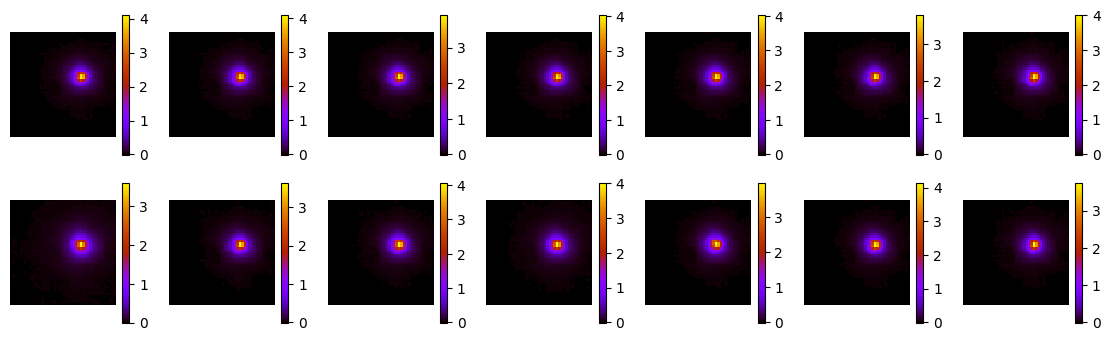

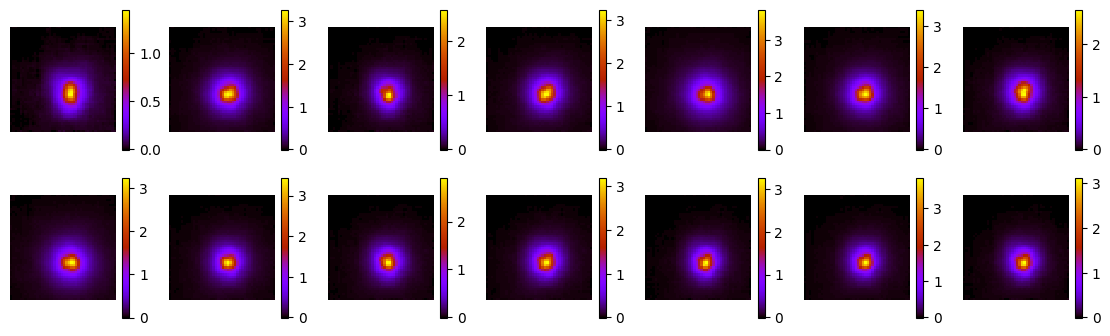

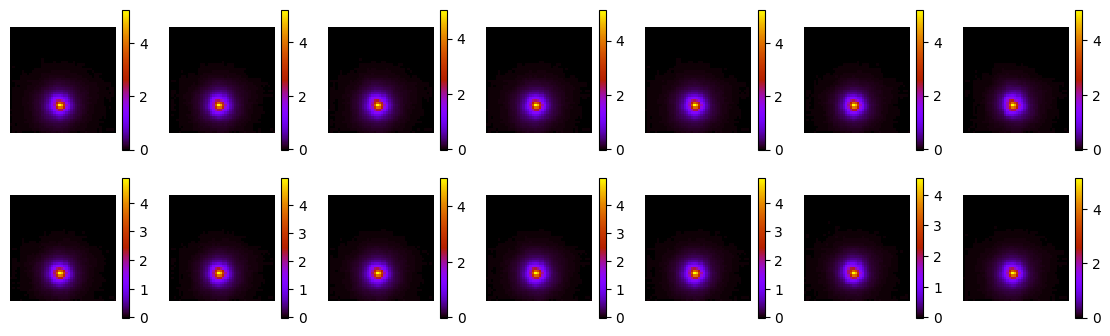

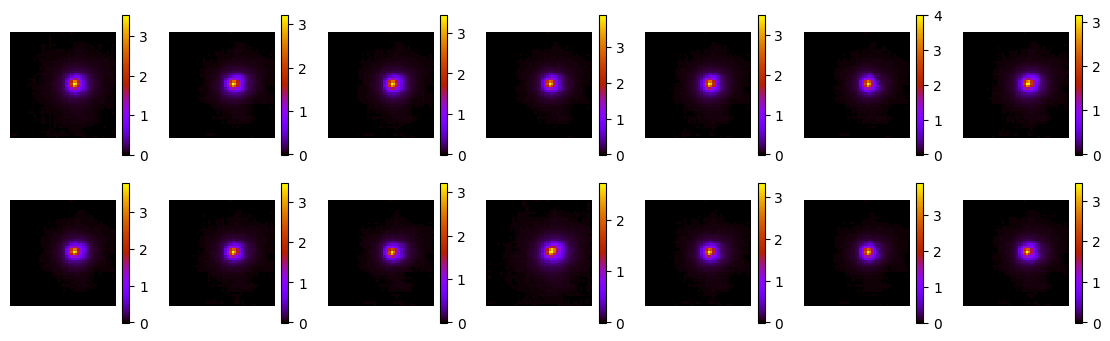

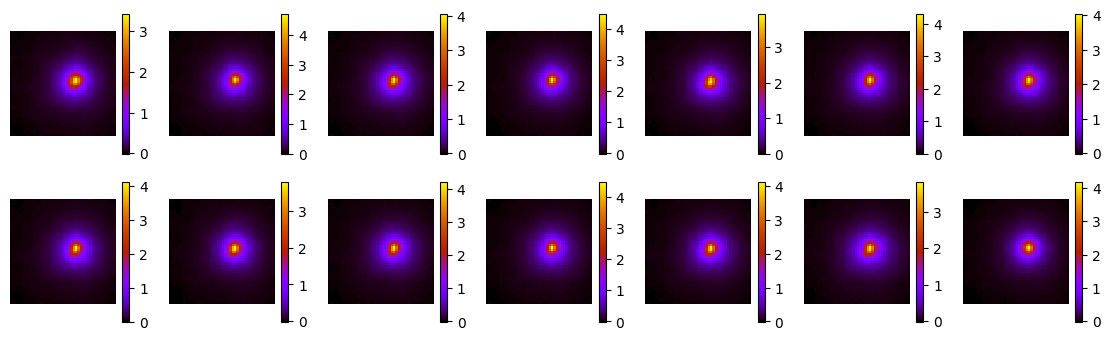

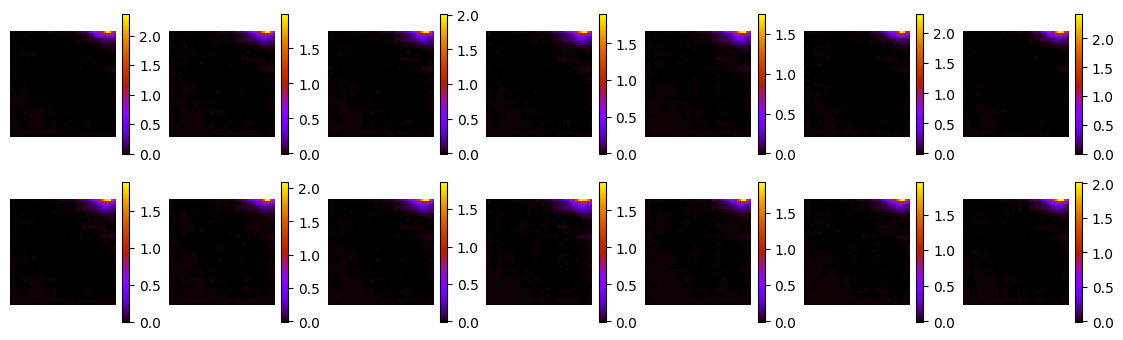

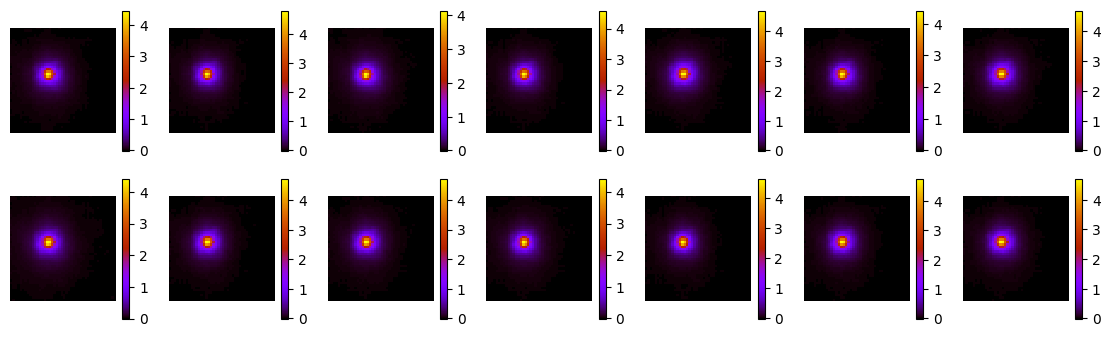

In [18]:
model.eval()

for _, (data, label) in enumerate(train_loader):
    data = data.to(device)
    cond = label[:, 9:].to(device)
    # cond = label[:, [9, -3, -2, -1]].to(device)
    (reconstruct, y_reconstruct, y_cond_reconstruct), latent_dist_z, latent_dist_w, latent_dist_c, \
            latent_sample_z, latent_sample_w, latent_sample_c, mask, w_mask = model(data, cond, taus)

    for j in range(7):

        columns = 7
        fig, axs = plt.subplots(2, columns, figsize=(columns * 2, 4))
        for i in range(2 * columns):
            tmp_w = torch.clone(latent_sample_w[j])
            tmp_cond = cond[j][:]
            tmp_data = data[j][:]

            # tmp_w[i // columns] += (i % 11 * 1) - 5

            if i:
                tmp_z = torch.randn(1, 8).to(device)
                (reconstruct_new_w, y_reconstruct_new, _), _, _, _,_, _, _, _, _ = model(tmp_data, tmp_cond.unsqueeze(0), 2.0000000000000012e-17, w2=tmp_w, z2=tmp_z)
            else:
                (reconstruct_new_w, y_reconstruct_new, _), _, _, _,_, _, _, _, _ = model(tmp_data, tmp_cond.unsqueeze(0), 2.0000000000000012e-17, w2=tmp_w)

            # tmp_w += torch.randn(8).to(device)

            x = reconstruct_new_w.cpu().detach().numpy()[0][0]

            im = axs[i//columns,i%columns].imshow(x,interpolation='none', cmap='gnuplot')
            axs[i//columns,i%columns].axis('off')
            fig.colorbar(im, ax=axs[i//columns,i%columns])
    break
    plt.show()


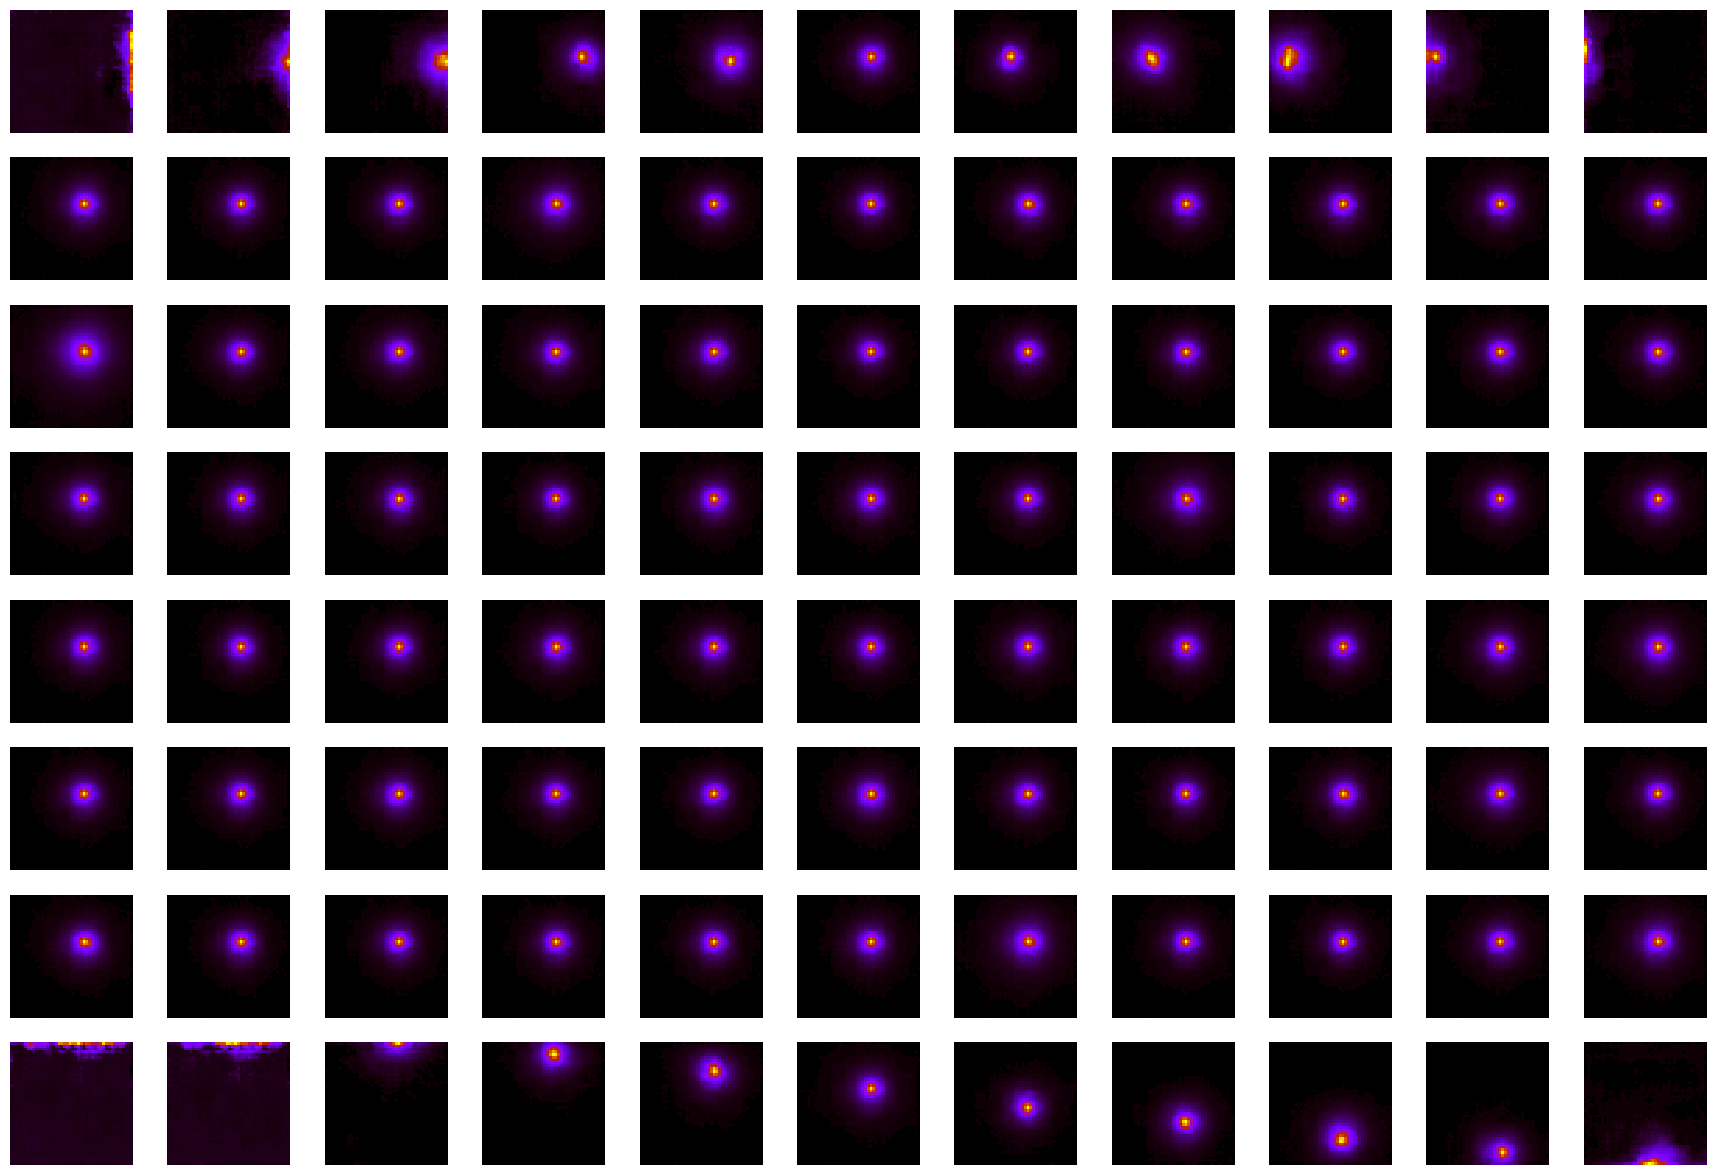

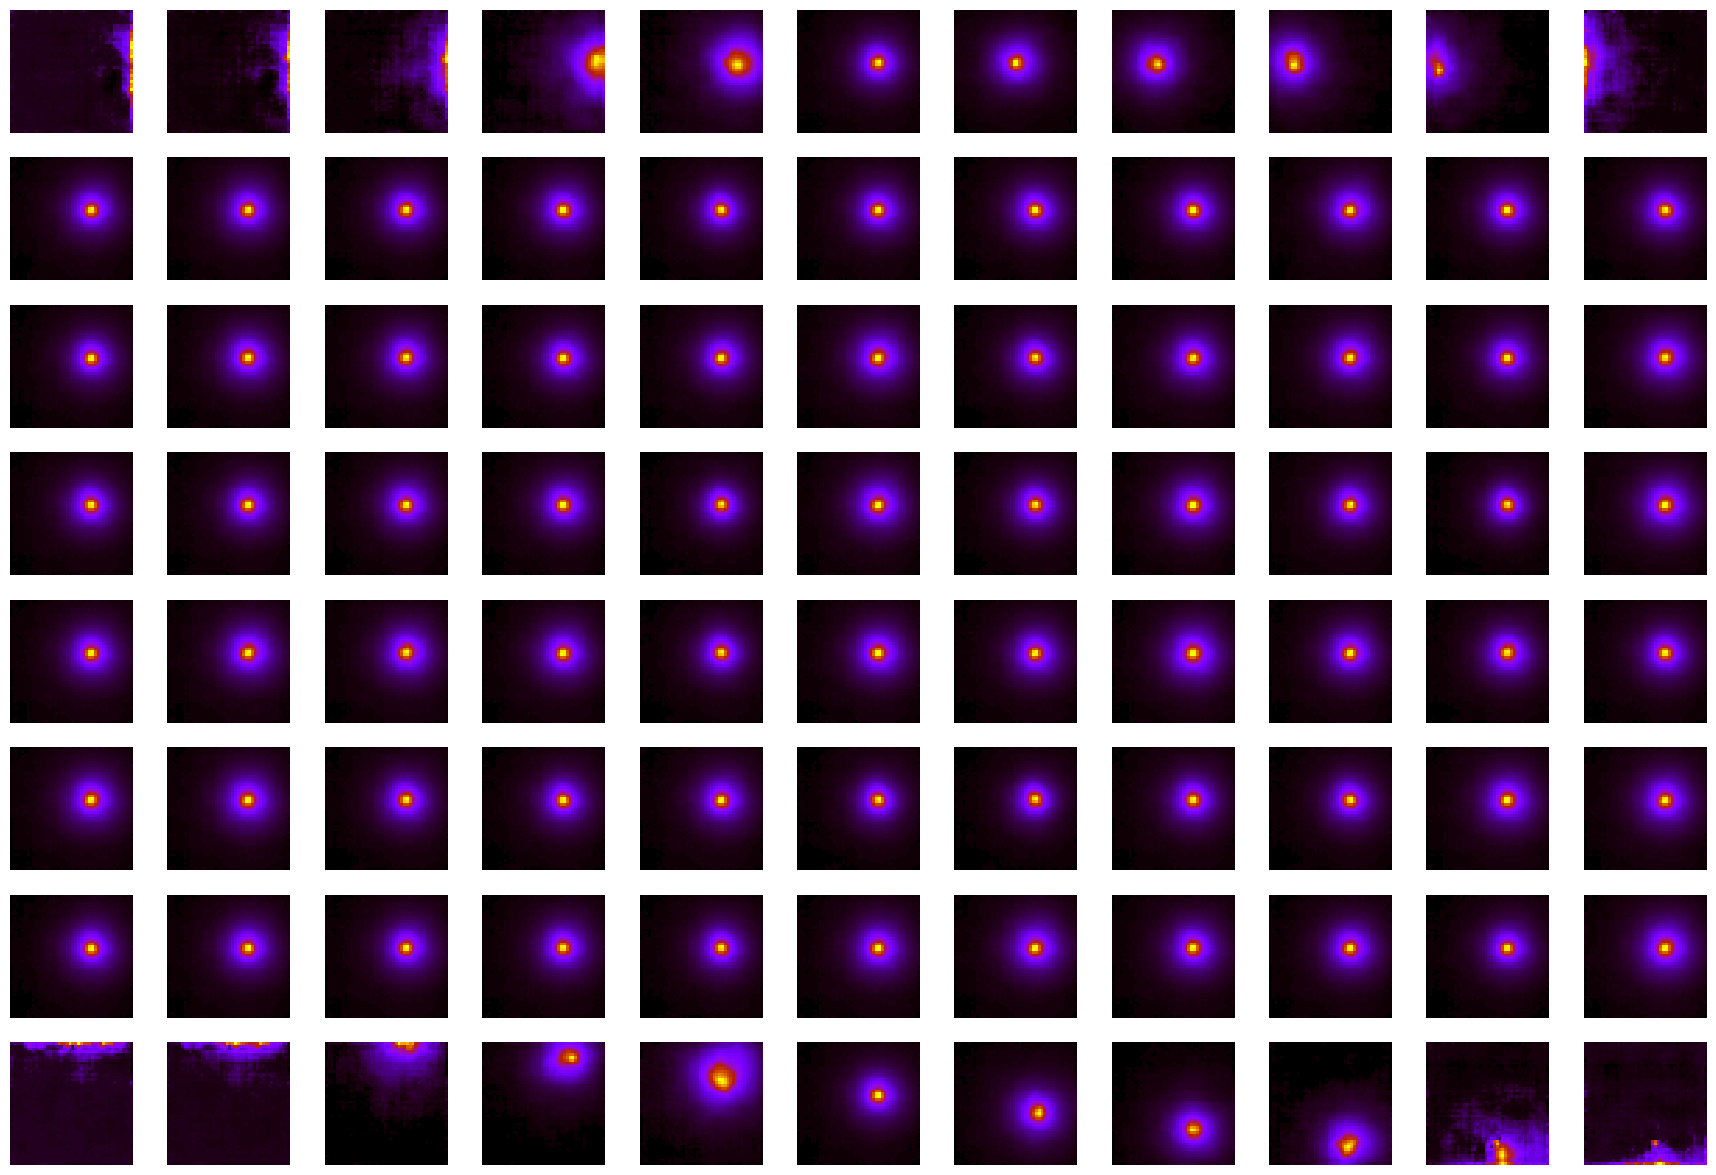

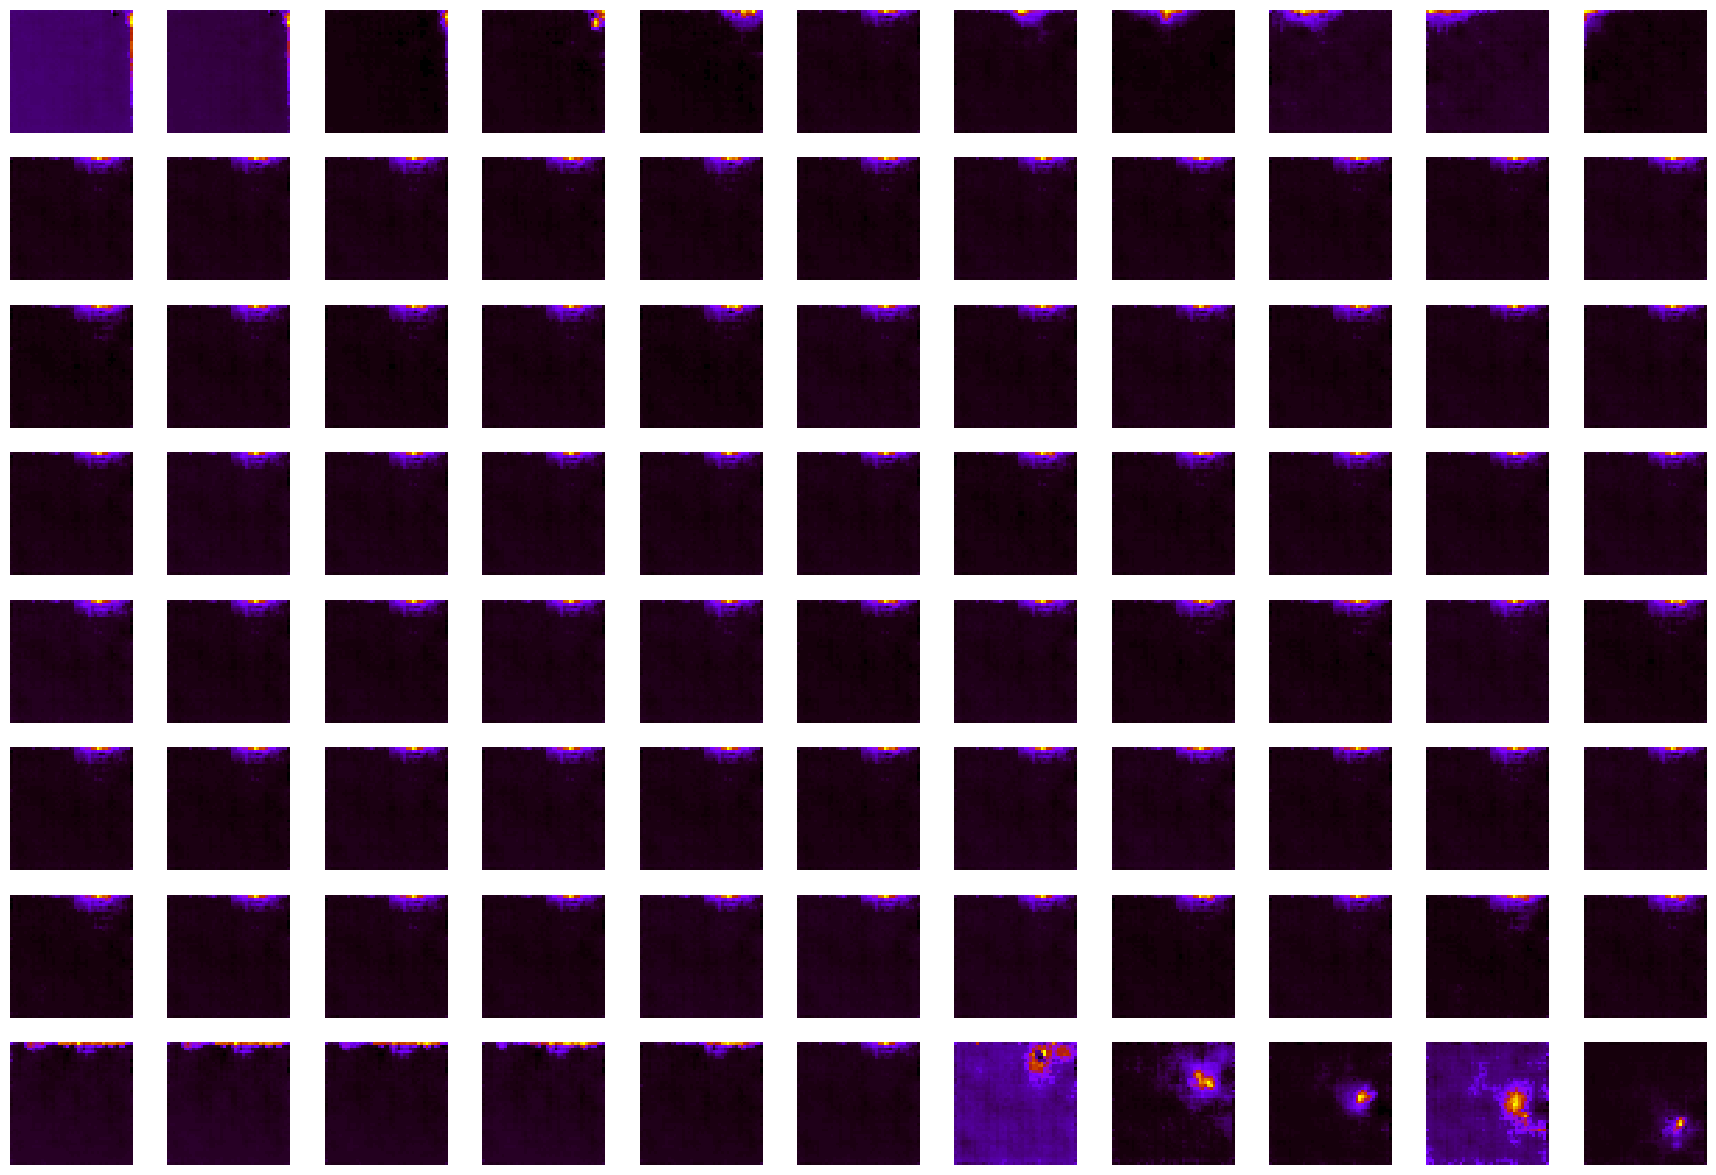

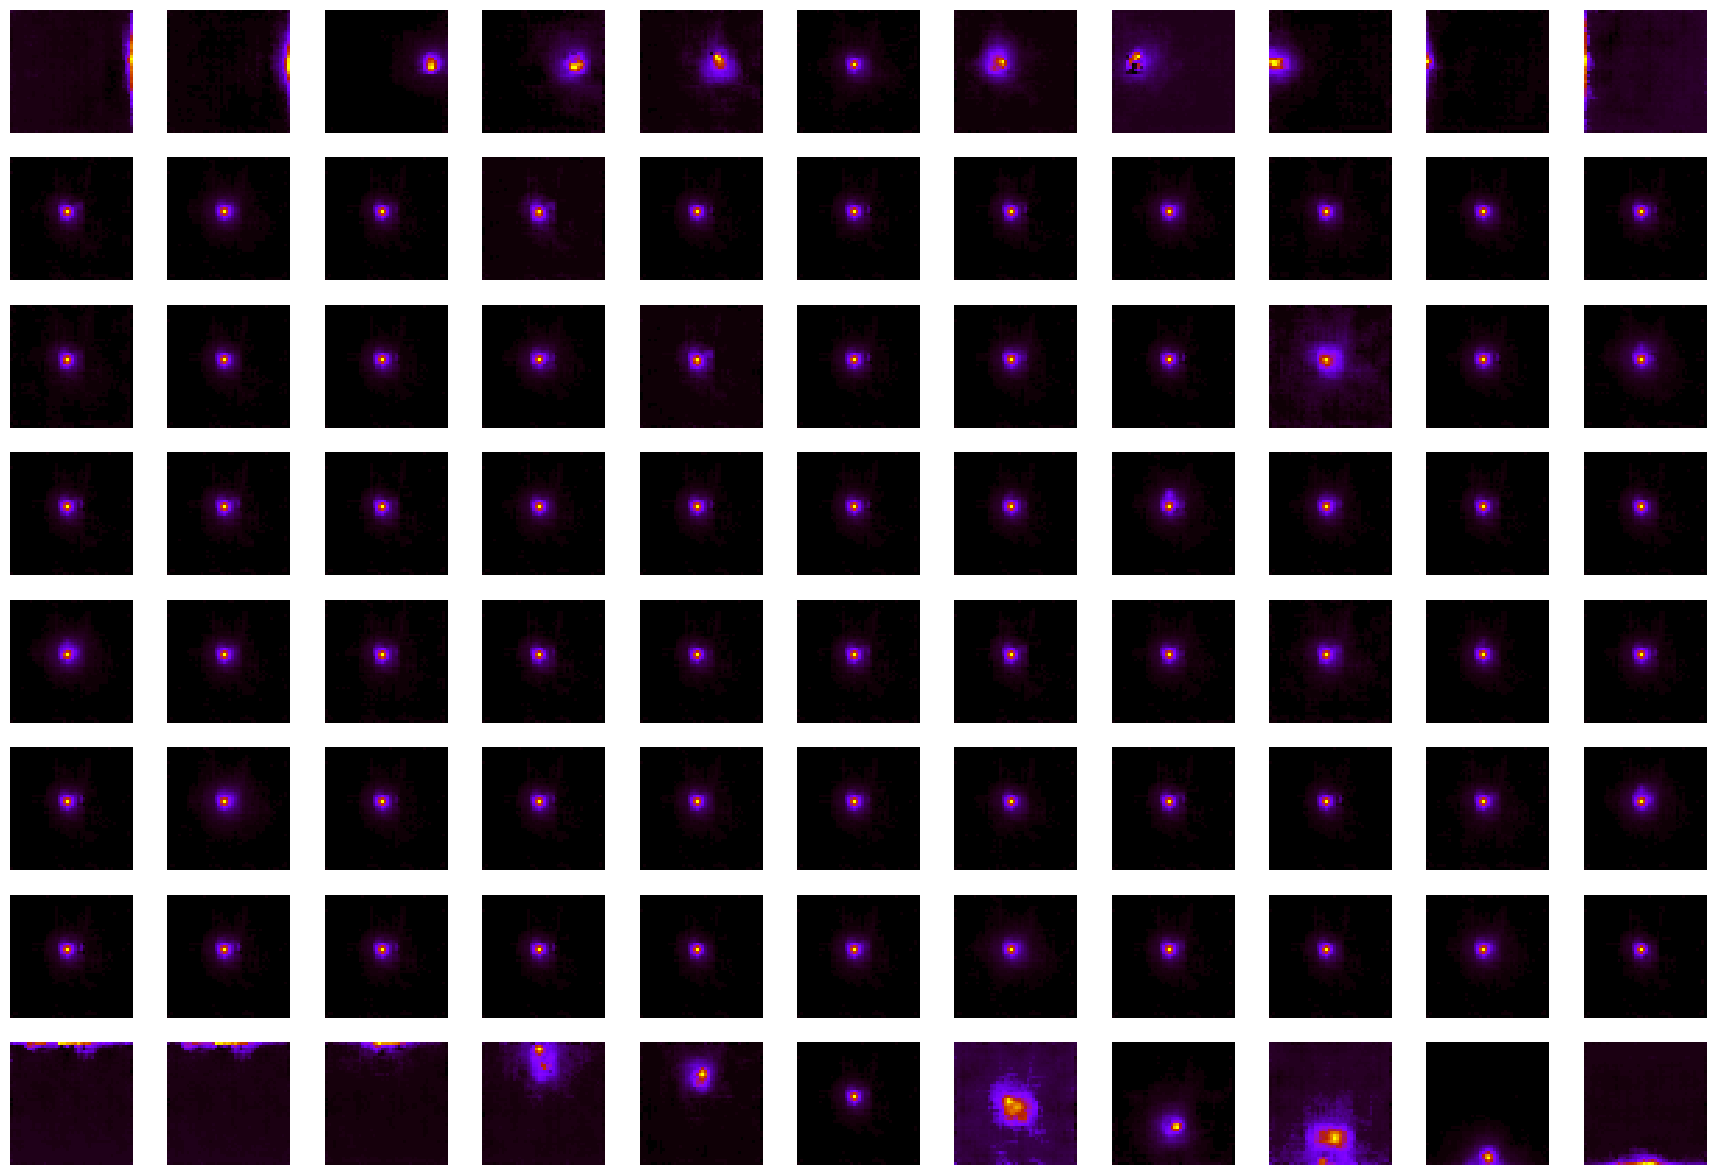

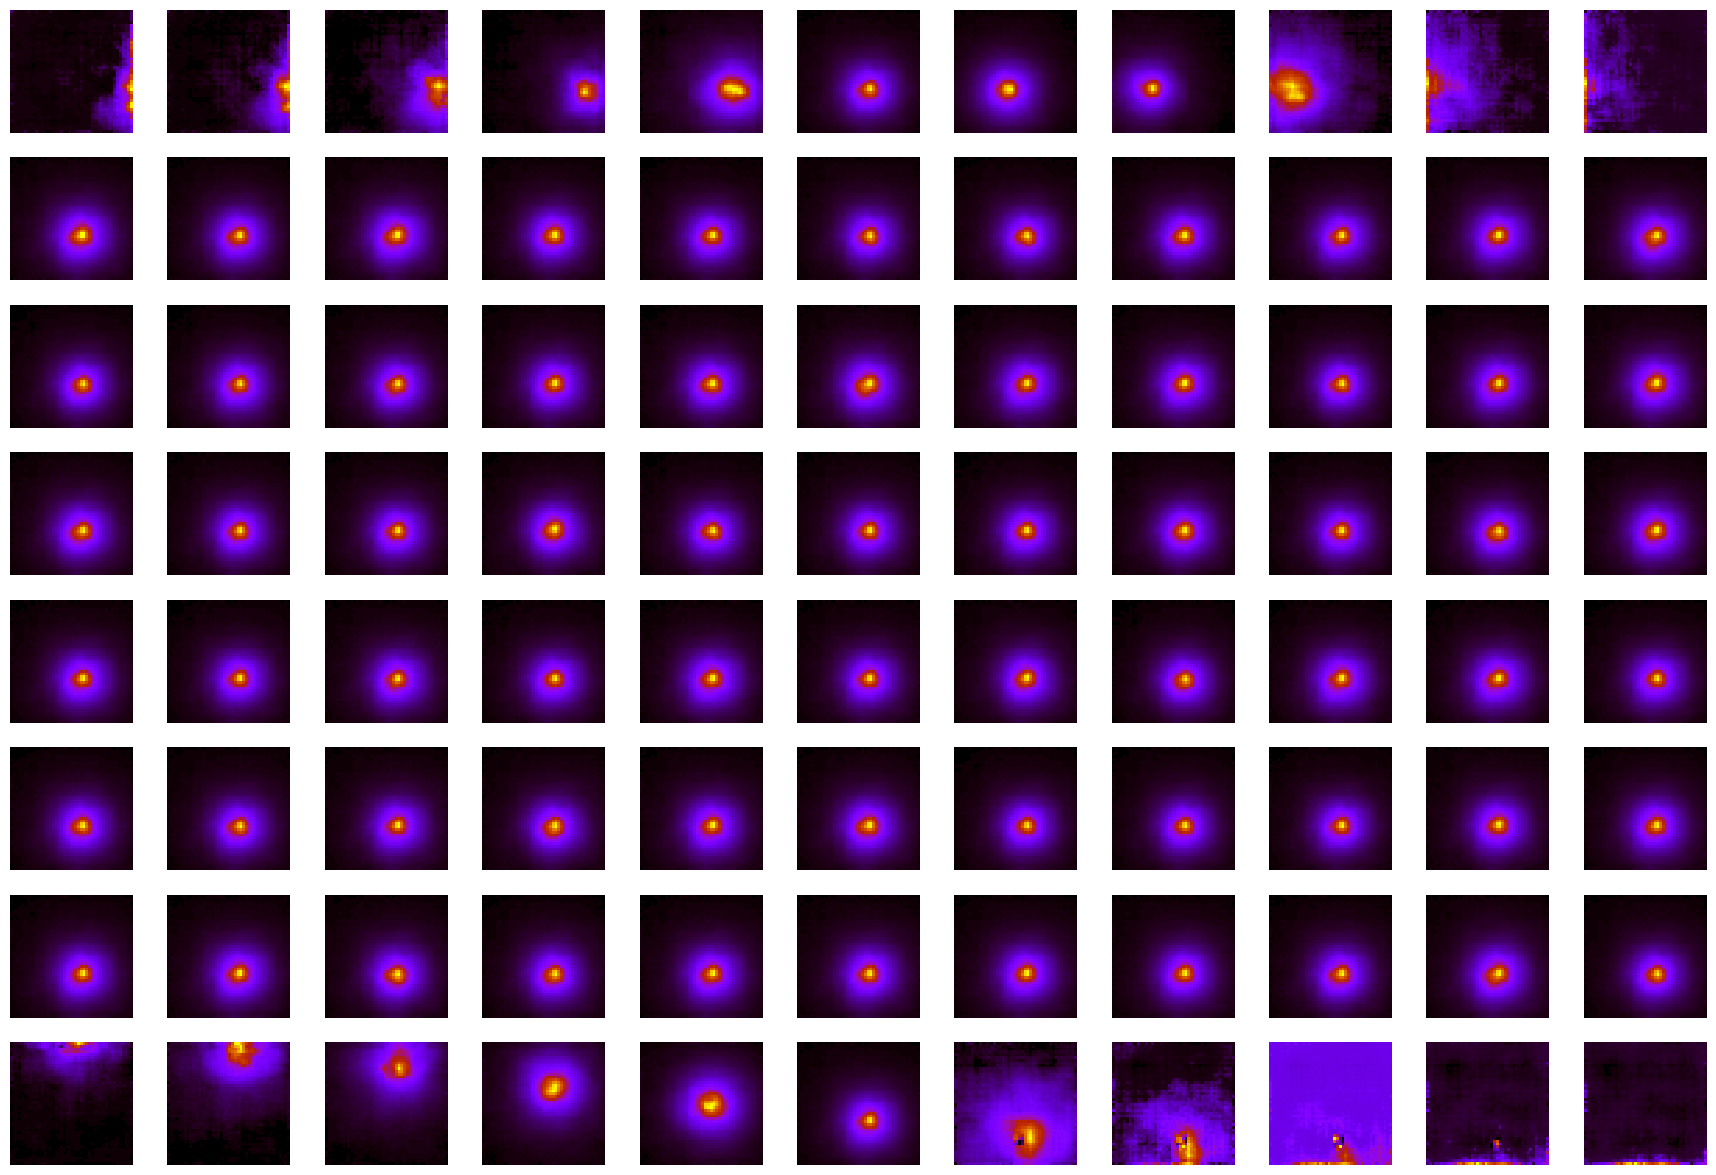

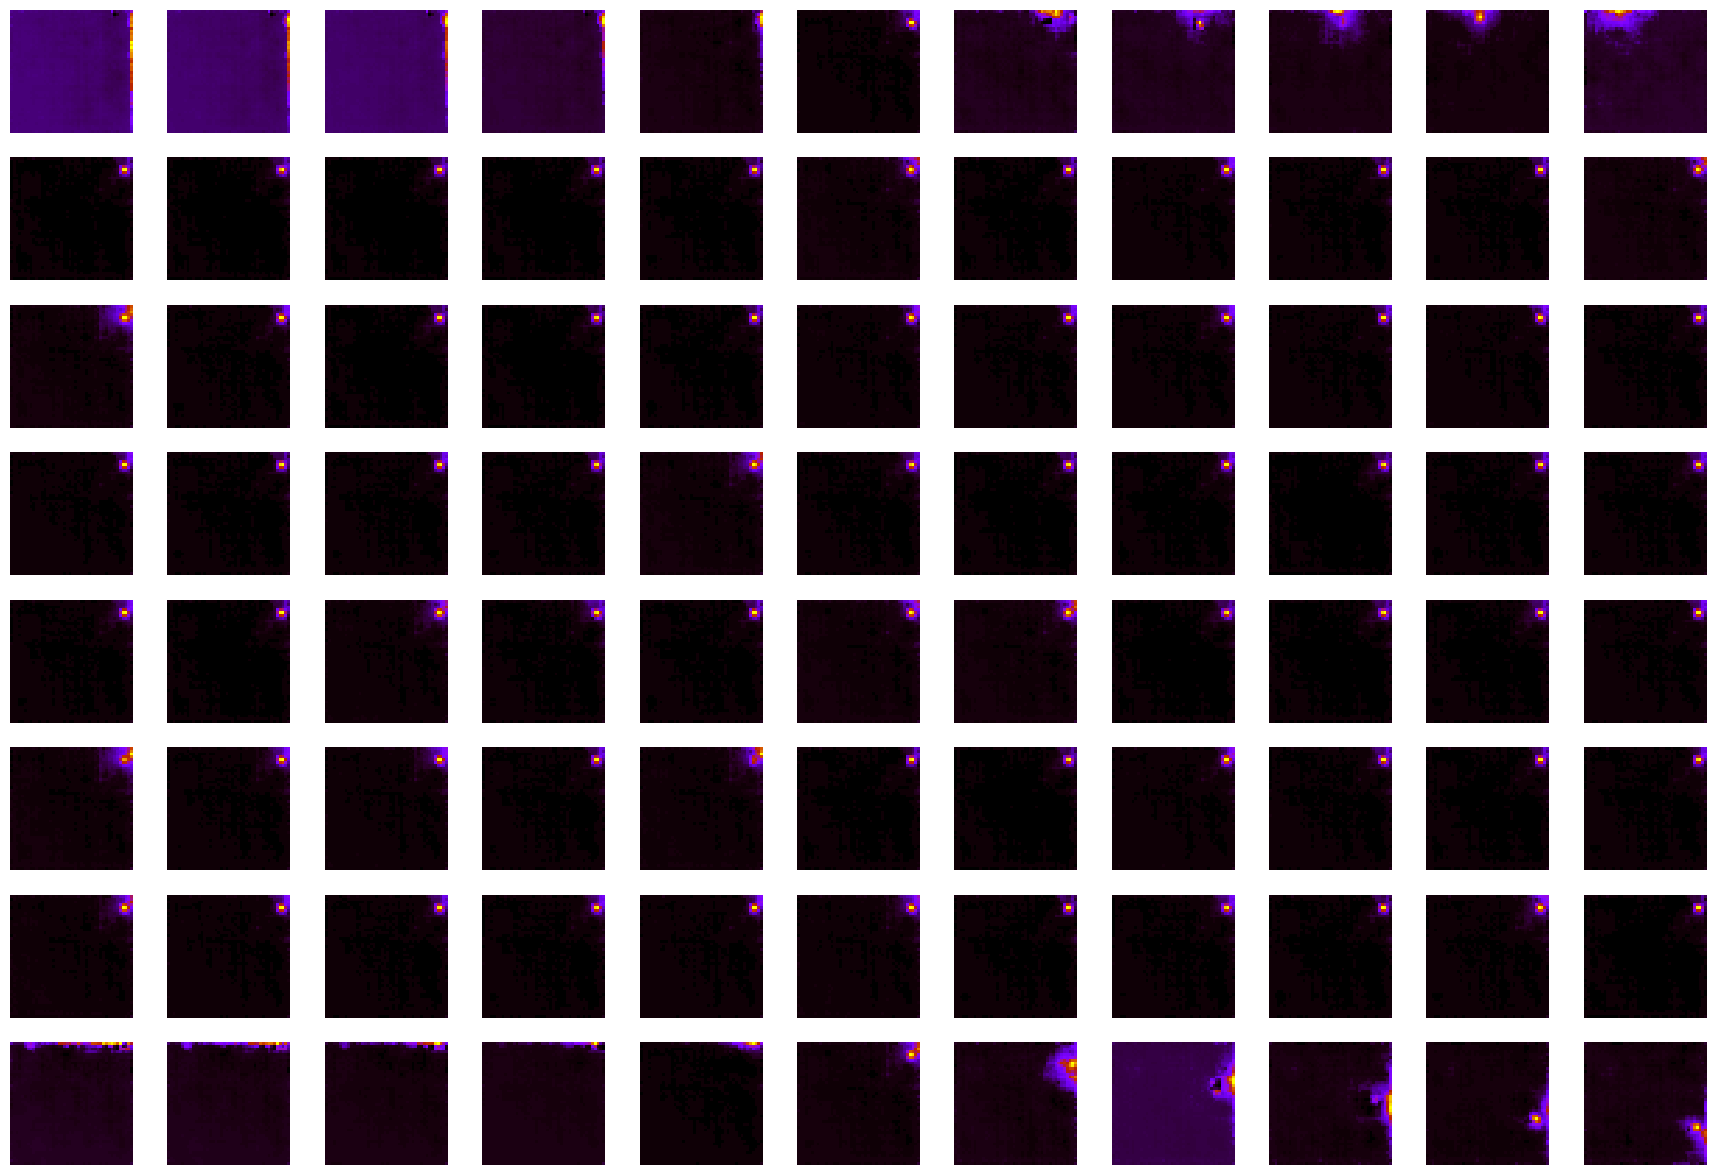

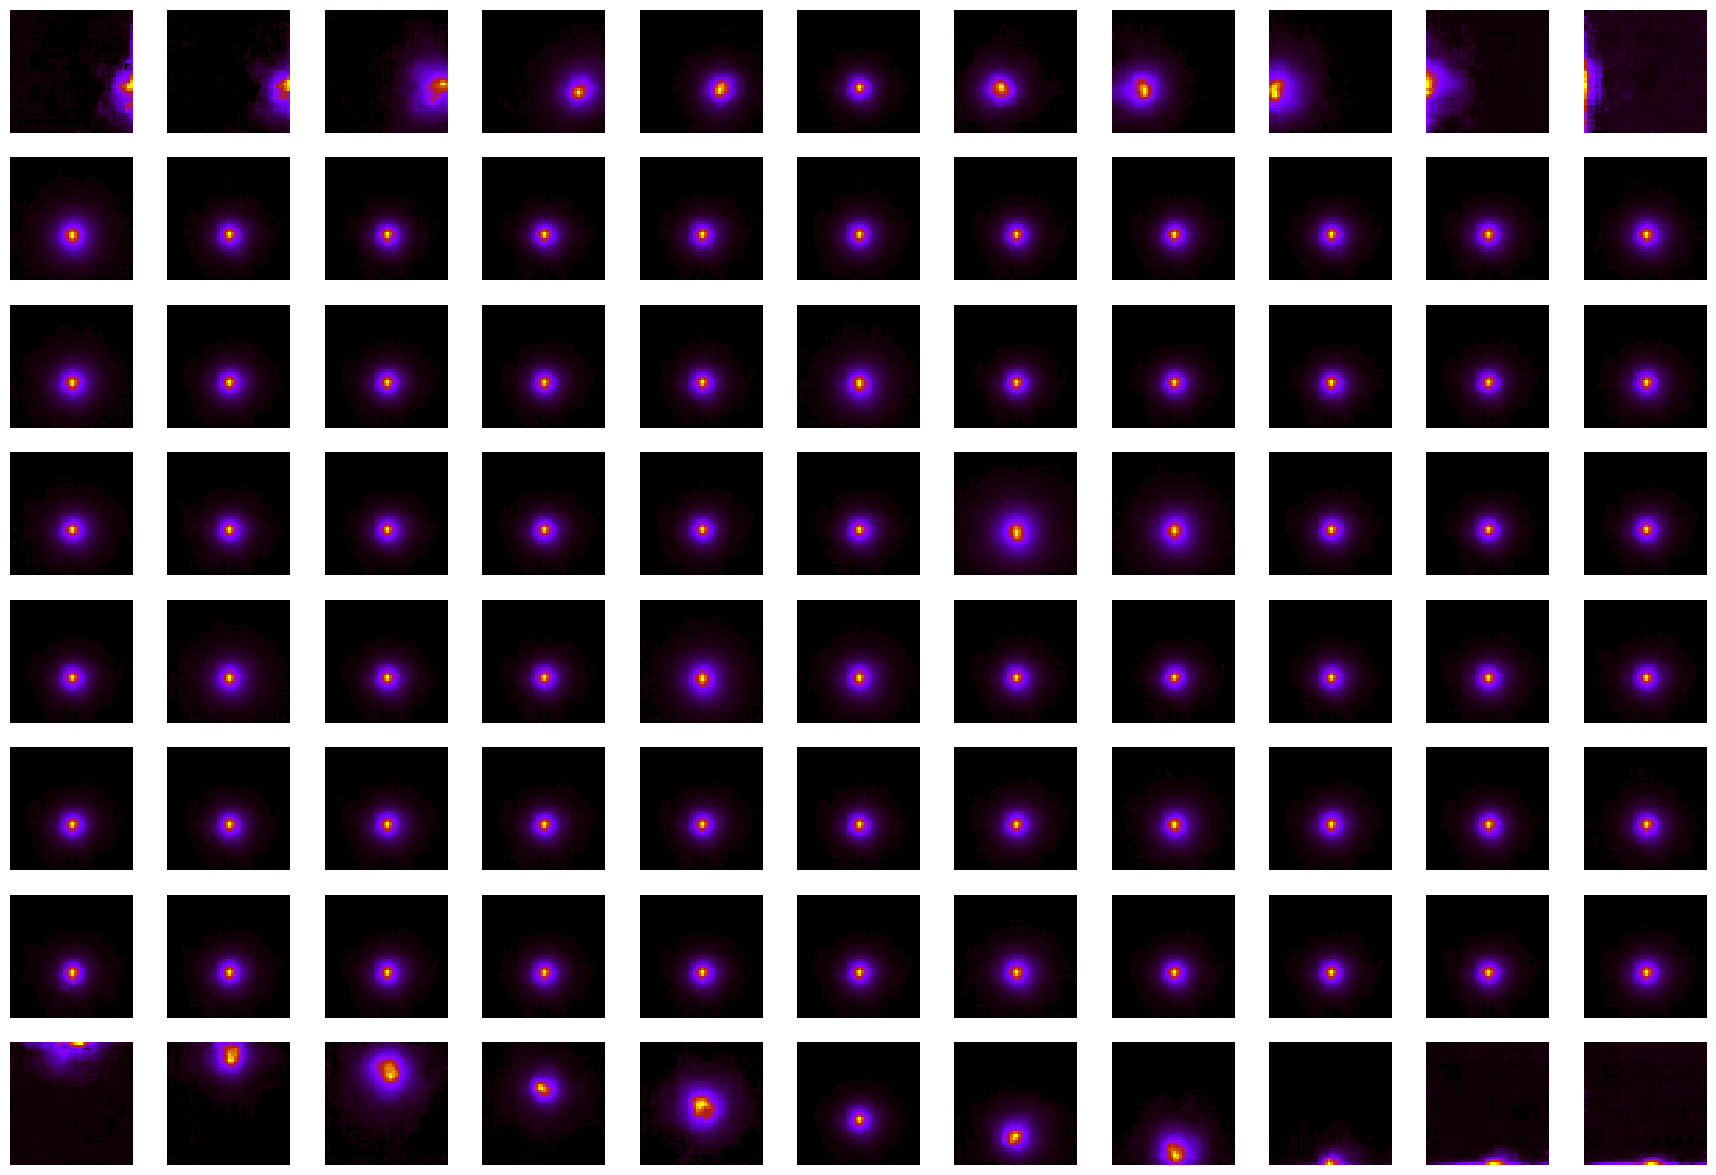

In [15]:
model.eval()

for _, (data, label) in enumerate(train_loader):
    data = data.to(device)
    cond = label[:, 9:].to(device)
    # cond = label[:, [9, -3, -2, -1]].to(device)

    (reconstruct, y_reconstruct, y_cond_reconstruct), latent_dist_z, latent_dist_w, latent_dist_c, \
            latent_sample_z, latent_sample_w, latent_sample_c, mask, w_mask = model(data, cond, taus)

    for j in range(7):

        columns = 11
        fig, axs = plt.subplots(8, columns, figsize=(columns * 2, 15))
        for i in range(8 * columns):
            tmp_w = torch.clone(latent_sample_w[j])
            tmp_data = data[j][:]
            tmp_cond = cond[j][:]

            tmp_w[i // columns] += ((i % 11 * 1) - 5) / 2
            # if i // 11 == 0:
            #     tmp_w[2] += (i % 11 * 0.5)
            # elif i // 11 == 1:
            #     tmp_w[3] += (i % 11 * 0.5)
            # else:
            #     tmp_w[2] += (i % 11 * 0.5)
            #     tmp_w[3] += (i % 11 * 0.5)

            (reconstruct_new_w, y_reconstruct_new, _), _, _, _,_, _, _, _, _ = model(tmp_data, tmp_cond.unsqueeze(0), 2.0000000000000012e-20, w2=tmp_w)

            # tmp_w += torch.randn(8).to(device)

            x = reconstruct_new_w.cpu().detach().numpy()[0][0]

            im = axs[i//columns,i%columns].imshow(x,interpolation='none', cmap='gnuplot')
            axs[i//columns,i%columns].axis('off')
            # fig.colorbar(im, ax=axs[i//columns,i%columns])
    plt.show()
    break


In [10]:
mask


tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]], grad_fn=<SelectBackward0>)

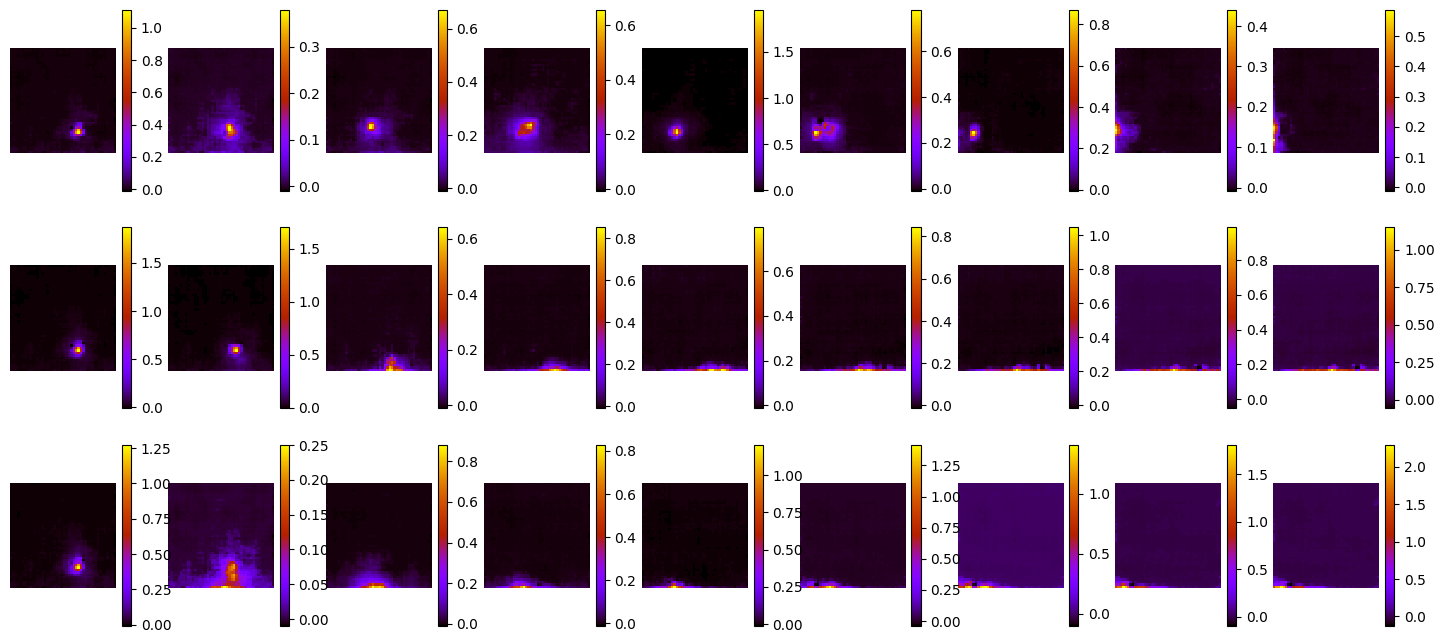

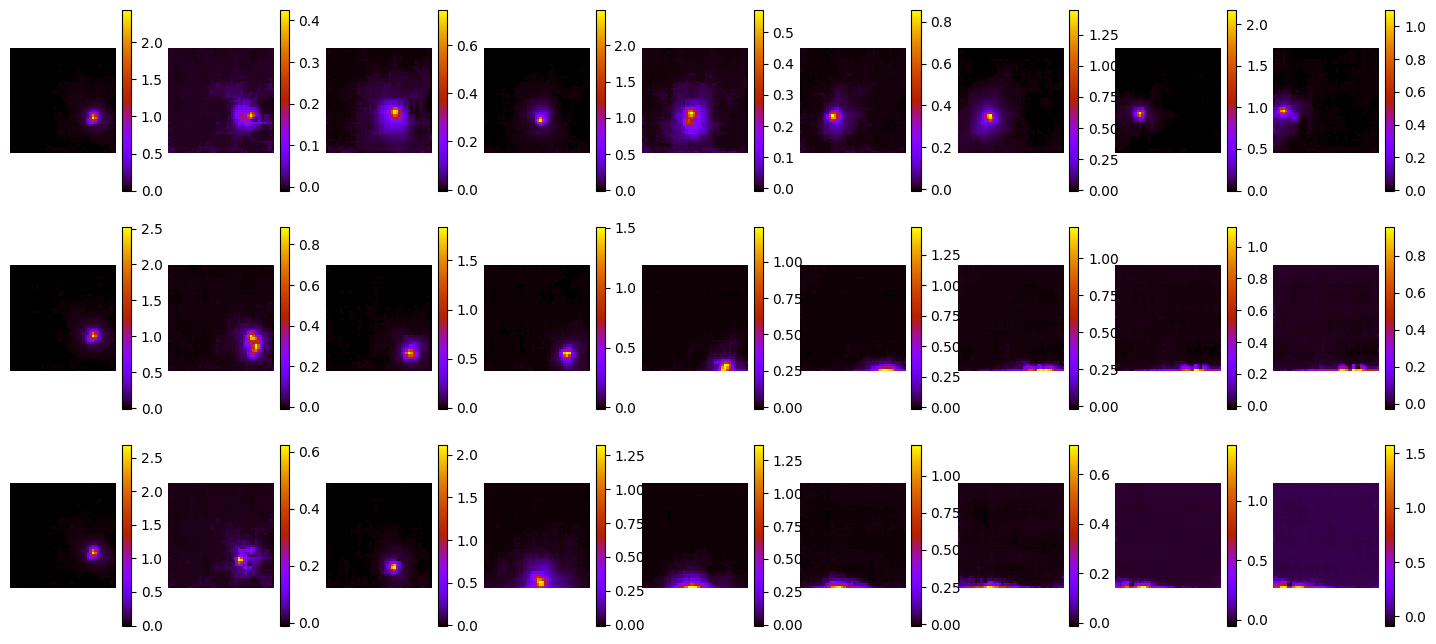

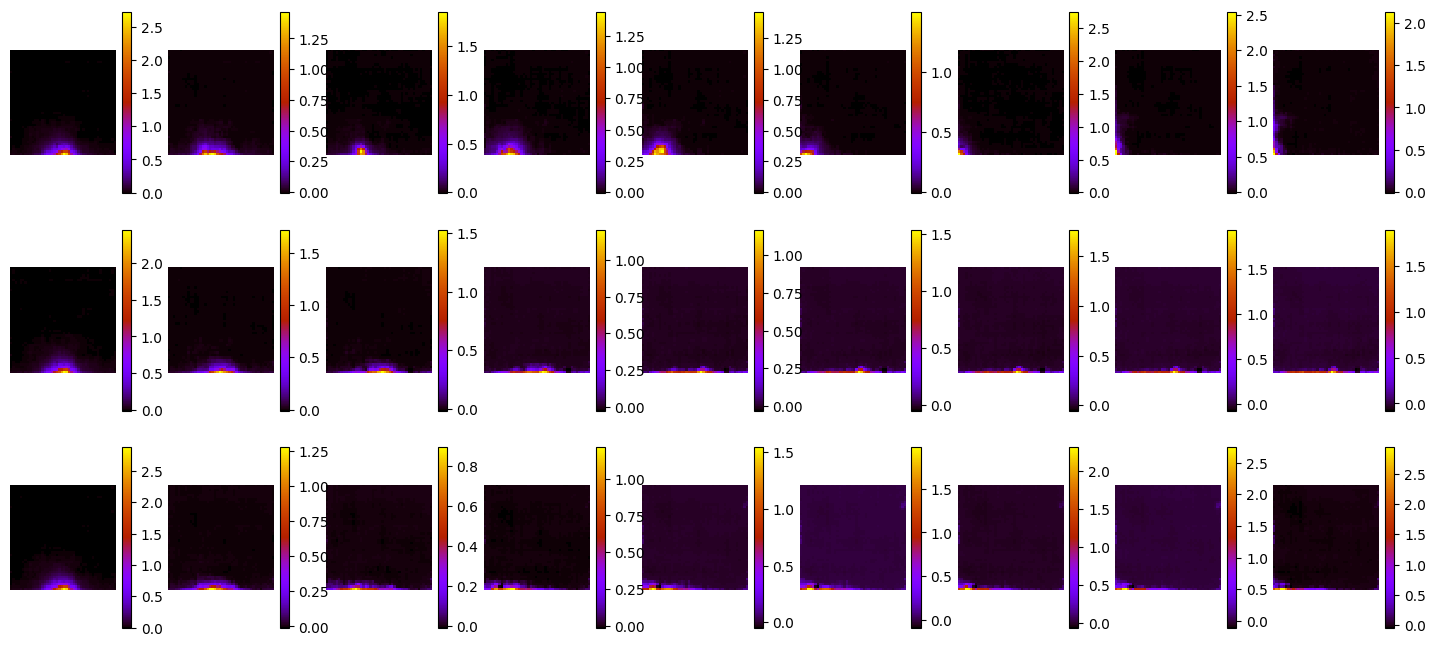

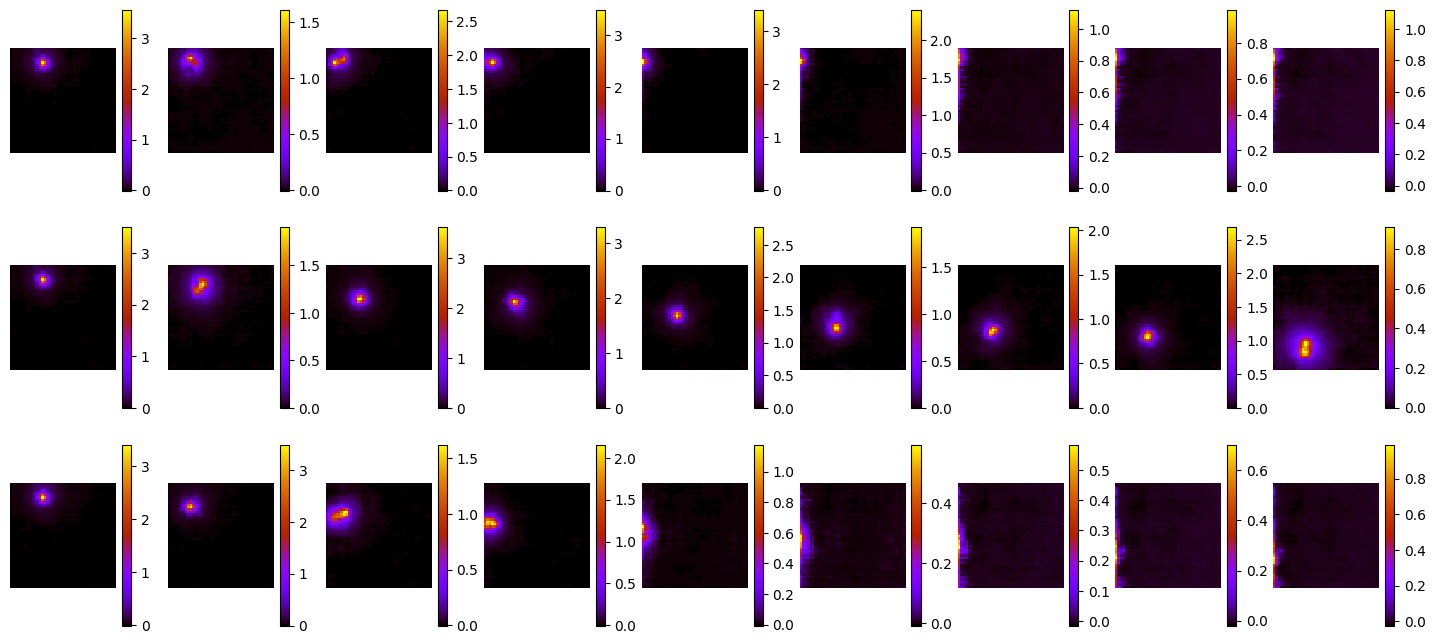

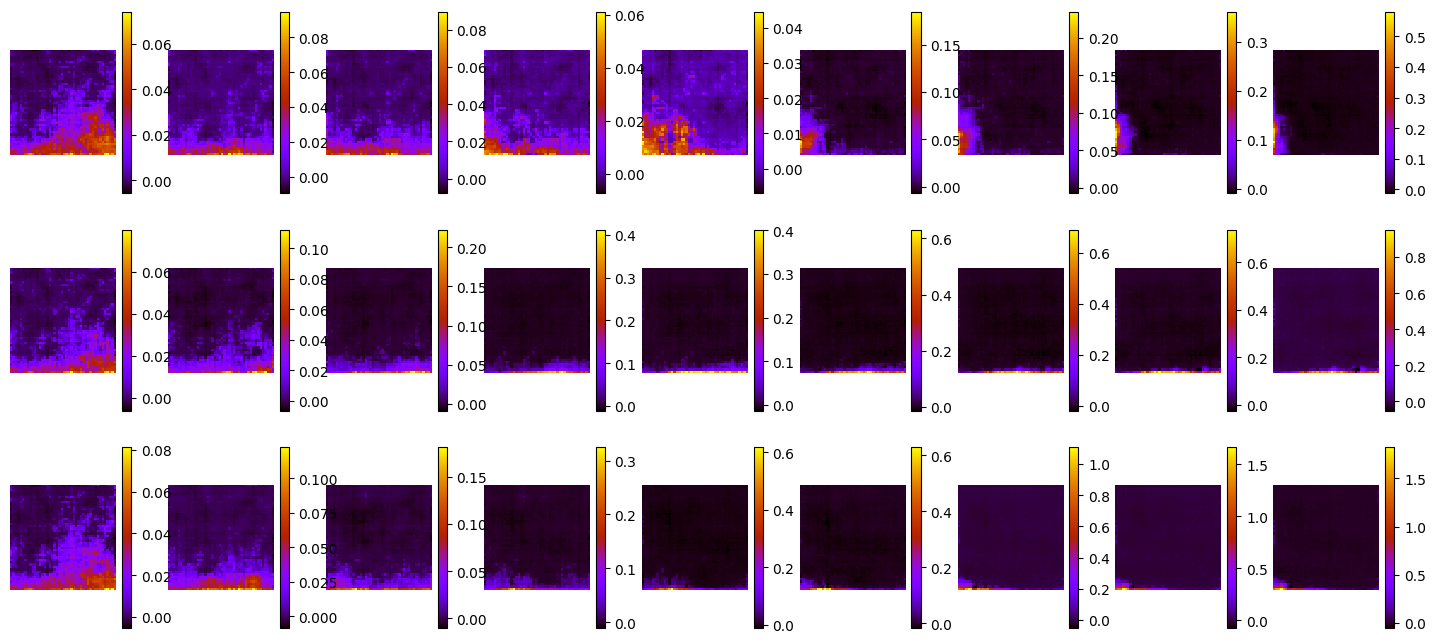

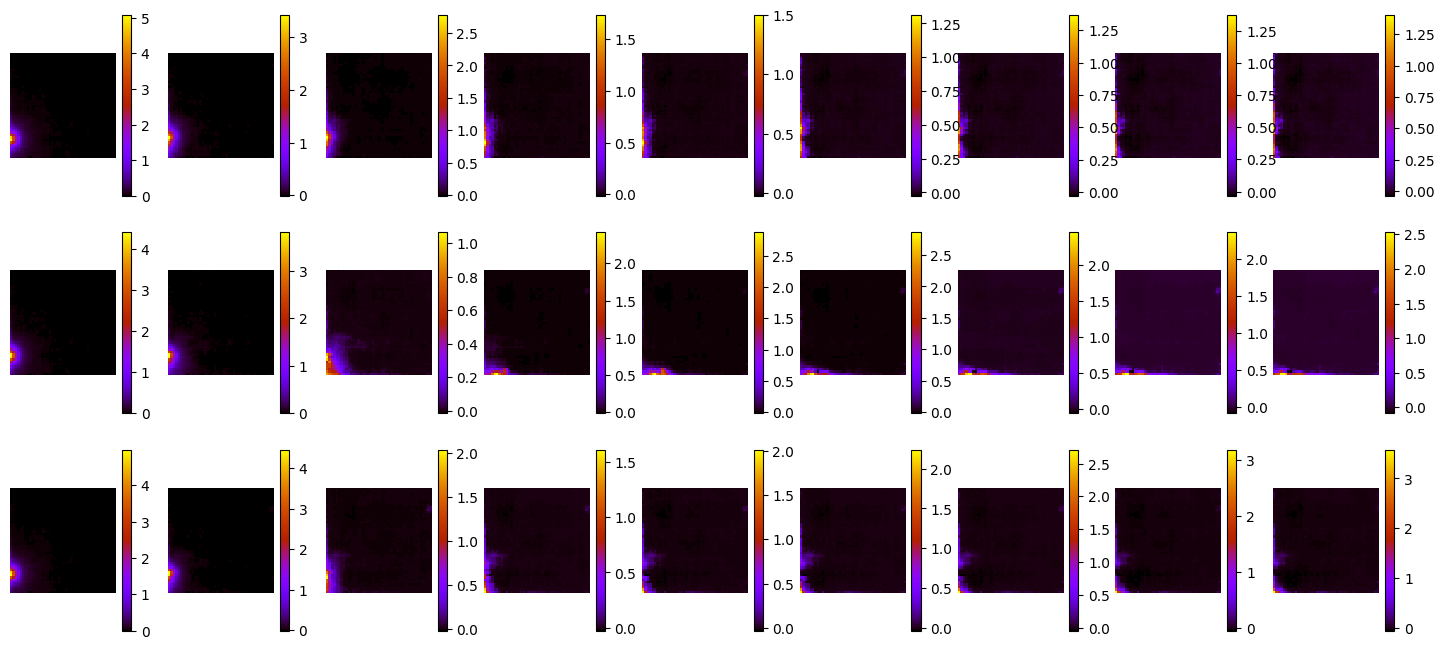

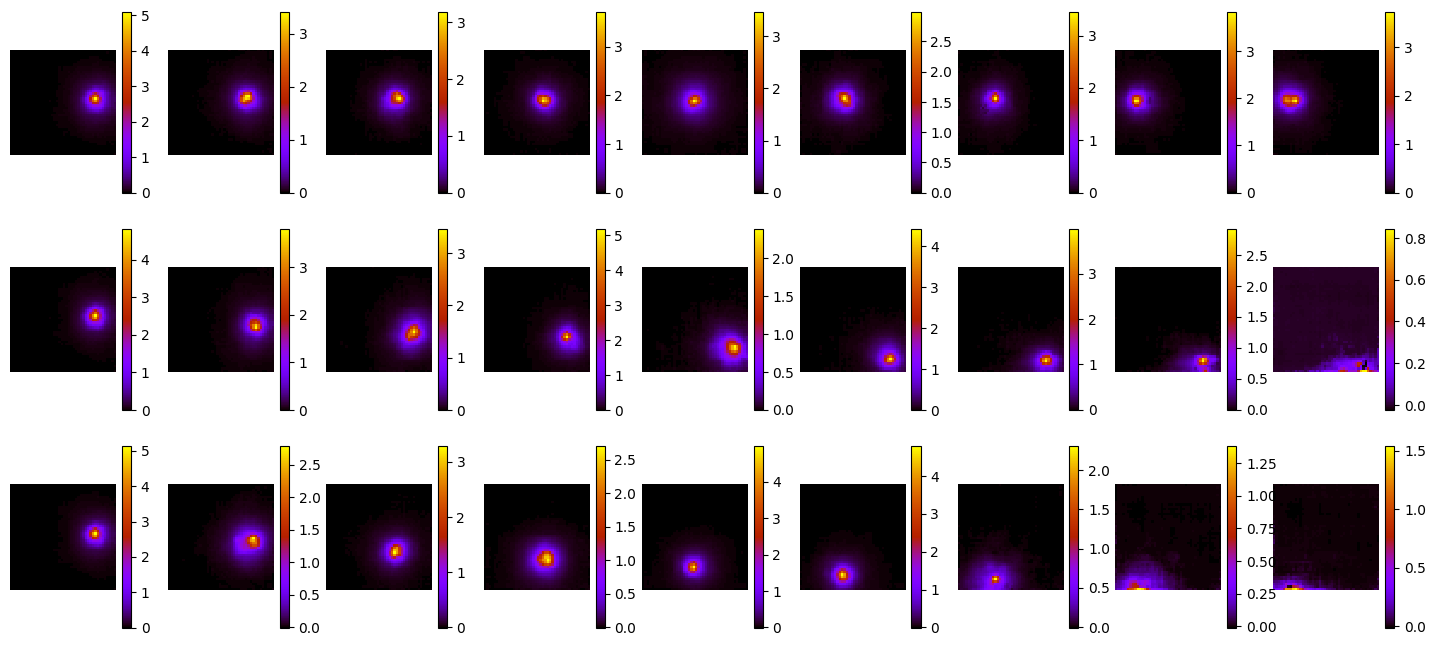

In [11]:

for _, (data, label) in enumerate(train_loader):
    data = data.to(device)
    cond = label[:, 9:].to(device)
    # cond = label[:, [9, -3, -2, -1]].to(device)

    (reconstruct, y_reconstruct, y_cond_reconstruct), latent_dist_z, latent_dist_w, latent_dist_c, \
            latent_sample_z, latent_sample_w, latent_sample_c, mask, w_mask = model(data, cond, taus)
    
    for j in range(7):

        columns = 9
        fig, axs = plt.subplots(3, columns, figsize=(columns * 2, 8))
        for i in range(3 * columns):
            tmp_w = torch.clone(latent_sample_w[j])
            tmp_data = data[j][:]
            tmp_cond = cond[j][:]

            # tmp_w[i // columns] += (i % 11 * 1) - 5
            step = 0.3
            if i // columns == 0:
                tmp_w[0] += (i % columns * step)
            elif i // columns == 1:
                tmp_w[7] += (i %  columns * step)
            # elif i // columns == 2:
            #     tmp_w[3] += (i % columns * step)
            else:
                tmp_w[0] += (i % columns * step)
                tmp_w[7] += (i % columns * step)

            (reconstruct_new_w, y_reconstruct_new, _), _, _, _,_, _, _, _, _ = model(tmp_data, tmp_cond.unsqueeze(0), 2.0000000000000012e-20, w2=tmp_w)

            # tmp_w += torch.randn(8).to(device)

            x = reconstruct_new_w.cpu().detach().numpy()[0][0]

            im = axs[i//columns,i%columns].imshow(x,interpolation='none', cmap='gnuplot')
            axs[i//columns,i%columns].axis('off')
            fig.colorbar(im, ax=axs[i//columns,i%columns])
    plt.show()
    
    break


In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image


data, label = next(iter(train_loader))
cond = label[:, 9:]
# cond = label[:, [9, -3, -2, -1]].to(device)

(reconstruct, y_reconstruct, y_cond_reconstruct), latent_dist_z, latent_dist_w, latent_dist_c, \
            latent_sample_z, latent_sample_w, latent_sample_c, mask, w_mask = model(data, cond, taus)


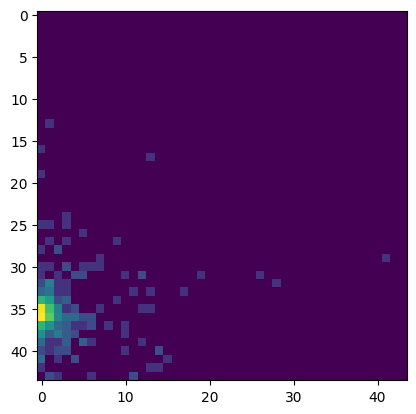

In [15]:
plt.imshow(data[2][0])

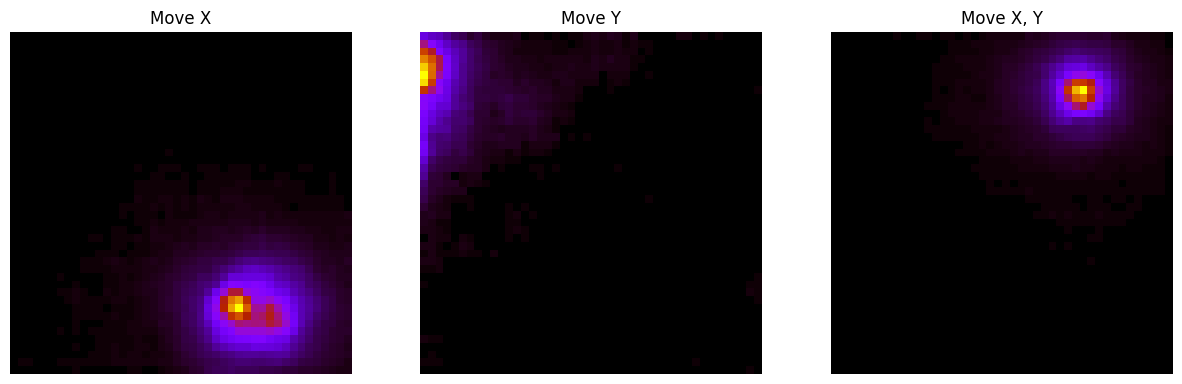

In [18]:
# IMG_NUM = 29
IMG_NUM = 2

tmp_w_y = torch.clone(latent_sample_w[IMG_NUM])
tmp_w_x = torch.clone(latent_sample_w[IMG_NUM])
tmp_w_yx = torch.clone(latent_sample_w[IMG_NUM])
tmp_w_size = torch.clone(latent_sample_w[IMG_NUM])

# Funkcja do generowania pojedynczej klatki
def generate_frame(frame_number):
    global tmp_w_y, tmp_w_x, tmp_w_yx
    step = 0.05

    plt.clf()

    (reconstruct_new_w, y_reconstruct_new, _), _, _, _,_, _, _, _, _= model(data[IMG_NUM], cond[IMG_NUM].unsqueeze(0), 2.0000000000000012e-17, w2=tmp_w_x)
    x = reconstruct_new_w.cpu().detach().numpy()[0][0]
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.title('Move X')
    plt.imshow(x, interpolation='none', cmap='gnuplot')

    (reconstruct_new_w, y_reconstruct_new, _), _, _, _,_, _, _, _, _ = model(data[IMG_NUM], cond[IMG_NUM].unsqueeze(0), 2.0000000000000012e-17, w2=tmp_w_y)
    x = reconstruct_new_w.cpu().detach().numpy()[0][0]
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.title('Move Y')
    plt.imshow(x, interpolation='none', cmap='gnuplot')

    # (reconstruct_new_w, y_reconstruct_new), _, _, _,_, _, _ = model(data[IMG_NUM], 2.0000000000000012e-17, w2=tmp_w_size)
    # x = reconstruct_new_w.cpu().detach().numpy()[0][0]
    # plt.subplot(1, 4, 3)
    # plt.axis('off')
    # plt.title('Change size')
    # plt.imshow(x, interpolation='none', cmap='gnuplot')

    (reconstruct_new_w, y_reconstruct_new, _), _, _, _,_, _, _, _, _ = model(data[IMG_NUM], cond[IMG_NUM].unsqueeze(0), 2.0000000000000012e-17, w2=tmp_w_yx)
    x = reconstruct_new_w.cpu().detach().numpy()[0][0]
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.title('Move X, Y')
    plt.imshow(x, interpolation='none', cmap='gnuplot')


    tmp_w_y[7] -= step

    tmp_w_x[0] -= step

    tmp_w_yx[0] -= step
    tmp_w_yx[7] -= step

    tmp_w_size[3] += step

# Tworzenie obiektu animacji
animation = FuncAnimation(plt.figure(figsize=(15, 5)), generate_frame, frames=50, interval=1000000)

# Zapisywanie animacji do pliku GIF
animation.save('animation.gif', writer='pillow', fps=6)

# Wyświetlanie animacji
plt.show()
